In [11]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from shapely.geometry.point import Point
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest
from pyproj import CRS
import string

In [2]:
from matplotlib import rcParams

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [3]:
!ls ../data/ch4_cases/sectors/solid_waste_clustermf

ENMAP01-____L1B-DT0000058098_20240123T060816Z_002_V010401_20240129T064520Z_dem.tif
ENMAP01-____L1B-DT0000058098_20240123T060816Z_002_V010401_20240129T064520Z.ZIP
ENMAP01-____L2B-DT0000058098_20240123T060816Z_002_V010401_20240129T064520Z.nc
PRS_L1_STD_OFFL_20240204054533_20240204054538_0001.zip
PRS_L2_STD_OFFL_20240204054533_20240204054538_0001.nc


In [4]:
filename = 'PRS_L2_STD_OFFL_20240204054533_20240204054538_0001.nc'

ds_cluster = xr.open_dataset(f'../data/ch4_cases/sectors/solid_waste_clustermf/{filename}', decode_coords='all')
ds = xr.open_dataset(f'../data/ch4_cases/sectors/solid_waste/{filename}', decode_coords='all')
df = pd.read_csv(f"../data/ch4_cases/sectors/solid_waste/{filename.replace('L2', 'L3').replace('.nc', '_plume0.csv')}", converters={'plume_bounds': literal_eval})

In [5]:
# Get the colormap colors
cmap = plt.get_cmap('hot_r')
my_cmap = cmap(np.arange(cmap.N))

slopen = 30
my_cmap[:,-1][:slopen] = np.linspace(0.2, 1.0, slopen)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [6]:
def add_scalebar(ax, lon, lat):
    # add scalebar
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(lon-1, lat),
                                  Point(lon, lat)],
                                 crs=4326)

    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon,
            south_lat_degree=lat,
            east_lon_degree=lon,
            north_lat_degree=lat,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)

    distance_meters = scale_points[0].distance(scale_points[1])
    scale_bar_location = 'lower left'
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='w',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )
    
    ax.add_artist(scalebar)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


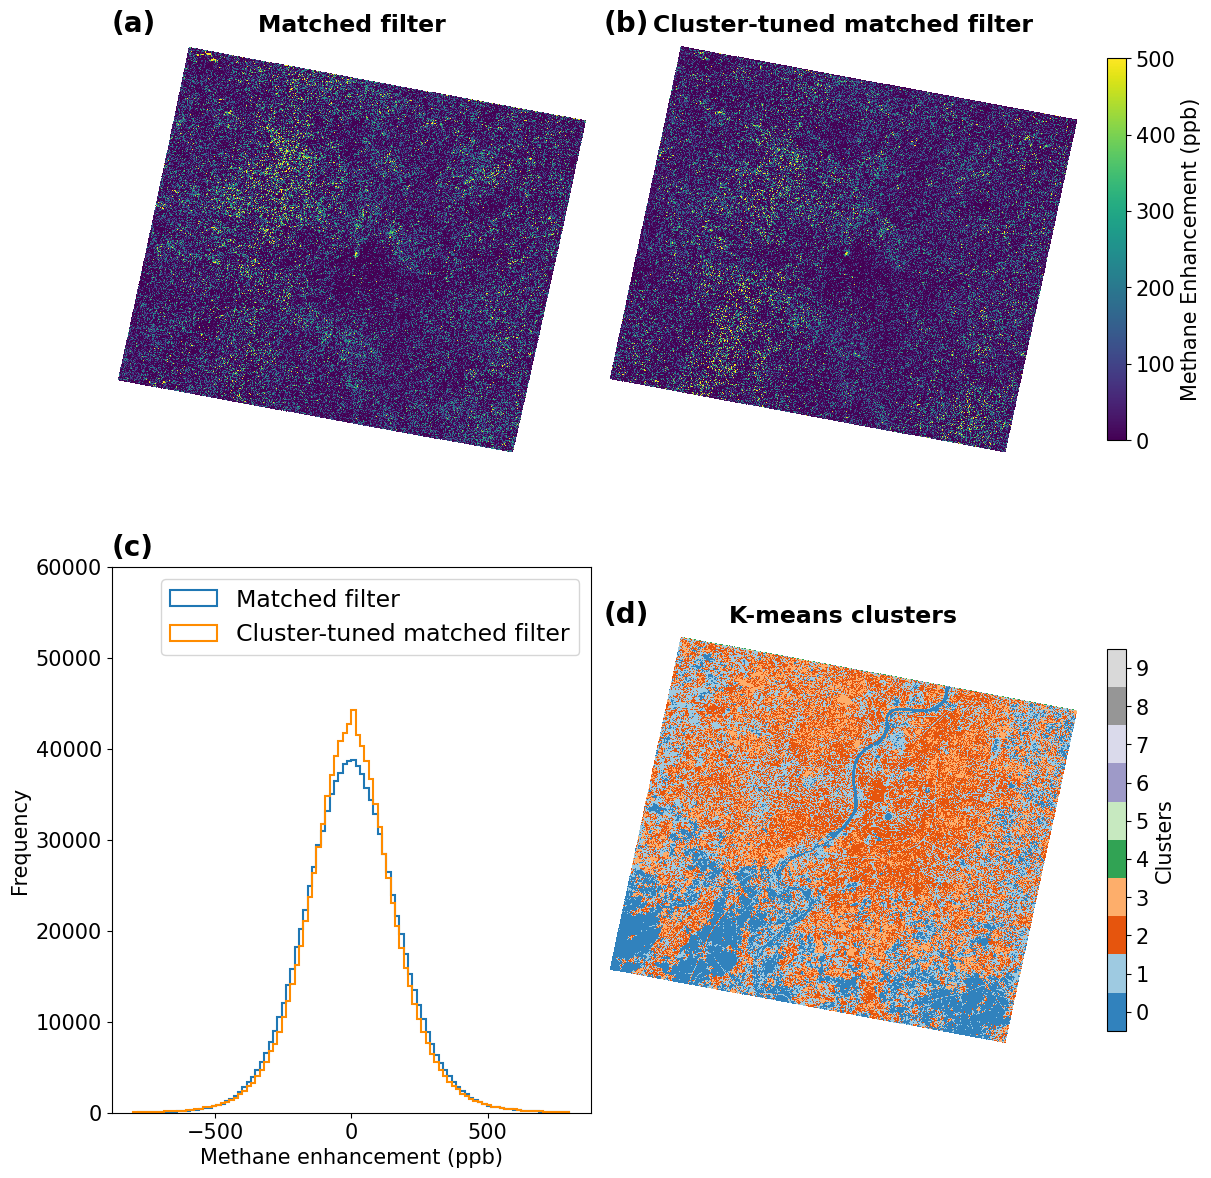

In [31]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), constrained_layout=True)

vmax = 500

# Create a 2x2 layout manually
ax1 = fig.add_subplot(2, 2, 1, projection=proj)
ax2 = fig.add_subplot(2, 2, 2, projection=proj)
# Last one is a normal subplot (no projection)
ax3 = fig.add_subplot(2, 2, 3)  # No projection keyword
ax4 = fig.add_subplot(2, 2, 4, projection=proj)


m = ds['ch4'].plot(ax=ax1, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='viridis', add_colorbar=False, rasterized=True)
# plt.colorbar(m, ax=ax1, shrink=0.7, label='Methane Enhancement (ppb)')
ax1.set_title('Matched filter')

m = ds_cluster['ch4'].plot(ax=ax2, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='viridis', add_colorbar=False, rasterized=True)
plt.colorbar(m, ax=ax2, shrink=0.7, label='Methane Enhancement (ppb)')
ax2.set_title('Cluster-tuned matched filter')

ax3.hist(ds['ch4'].values.ravel(), bins=100, range=(-800, 800), histtype='step', edgecolor='C0', linewidth=1.5, label='Matched filter')
ax3.hist(ds_cluster['ch4'].values.ravel(), bins=100, range=(-800, 800), histtype='step', edgecolor='darkorange', linewidth=1.5, label='Cluster-tuned matched filter')
ax3.set_xlabel('Methane enhancement (ppb)')
ax3.set_ylabel('Frequency')
ax3.set_ylim(0, 6e4)
ax3.legend()

n_clusters = len(np.unique(ds_cluster['segmentation'])) + 1
cmap_cluster = plt.get_cmap('tab20c', n_clusters)

m = ds_cluster['segmentation'].plot(ax=ax4, x='longitude', y='latitude',
                     cmap=cmap_cluster,
                     vmin = ds_cluster['segmentation'].min() - 0.5,
                     vmax = ds_cluster['segmentation'].max() + 0.5,
                     add_colorbar=False,
                                    rasterized=True)
# add colorbar
cbar = fig.colorbar(m, ticks=np.arange(ds_cluster['segmentation'].min(), ds_cluster['segmentation'].max() + 1),
                    ax=ax4, label='Clusters', shrink=0.7)

ax4.set_title('K-means clusters')

for n, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

ax1.set_frame_on(False)
ax2.set_frame_on(False)
ax4.set_frame_on(False)

# for ax in axs:
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=0.4, color='w', alpha=0.5, linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False

fig.savefig('../figures/cluster_mf.pdf')